In [2]:
%load_ext autoreload
%autoreload 2

# Analyzing the trained model

In [3]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, GaborLayerLogSigma_, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2024-07-09 15:23:39.013701: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 15:23:39.043542: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 15:23:39.044015: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 15:23:39.548178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-09 15:23:40.373193: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-09 15:23:40.373211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA d

In [5]:
# jax.config.update("jax_debug_nans", False)

In [6]:
import matplotlib.pyplot as plt

In [7]:
id = "q8ma57ba"

In [8]:
api = wandb.Api()
prev_run = api.run(f"jorgvt/ParametricKnowledgeDistillation/{id}")

In [9]:
config = ConfigDict(prev_run.config["_fields"])

In [10]:
for file in prev_run.files():
    file.download(root=prev_run.dir, replace=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [11]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=True)(inputs)
        outputs = nn.Conv(features=3, kernel_size=(1,1), strides=1, padding="SAME")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        outputs = nn.Conv(features=6, kernel_size=(config.CS_KERNEL_SIZE,config.CS_KERNEL_SIZE), strides=1, padding="SAME")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GDN(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, strides=1, padding="SAME", apply_independently=False)(outputs)
        outputs = nn.Conv(features=config.N_GABORS, kernel_size=(config.GABOR_KERNEL_SIZE,config.GABOR_KERNEL_SIZE), strides=1, padding="SAME")(outputs)
        outputs = GDN(kernel_size=config.GDNSPATIOFREQ_KERNEL_SIZE, strides=1, padding="SAME", apply_independently=False)(outputs)
        return outputs

## Define the metrics with `clu`

In [19]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")
    correlation_l: metrics.Average.from_output("correlation_l")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [20]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [21]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [22]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [23]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [24]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Loading the weights

In [27]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNER_LR), input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [28]:
import flax

In [29]:
def check_trainable(path):
    if not config.A_GDNSPATIOFREQORIENT:
        if ("GDNSpatioFreqOrient_0" in path) and ("A" in path):
            return True
    if "Color" in path:
        if not config.TRAIN_JH:
            return True
    if "CenterSurroundLogSigmaK_0" in path:
        if not config.TRAIN_CS:
            return True
    return False

In [30]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))

In [32]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNER_LR),
    "non_trainable": optax.set_to_zero(),
}

In [33]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [34]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

Instantiate the checkpointer to reload the already trained model:

In [35]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [45]:
state = state.replace(params=orbax_checkpointer.restore(f"{prev_run.dir}/model-best")["params"])

In [46]:
# state = orbax_checkpointer.restore(f"{prev_run.dir}/model-best", item=state)
# state = orbax_checkpointer.restore(f"{prev_run.dir}/model-0", item=state)

In [47]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
param_count

2733104

## Forward pass of the generated stimuli

In [48]:
from functools import partial

In [49]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [50]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [51]:
import cv2

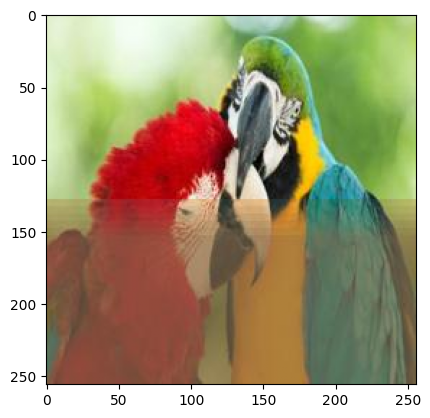

In [54]:
kk = cv2.imread("loritos_jesus_2.jpeg")
kk = cv2.cvtColor(kk, cv2.COLOR_BGR2RGB)/255.
plt.imshow(kk)
plt.show()
kk = kk[None,:]

In [55]:
%%time
outputs, extras = forward_intermediates(state, kk)
outputs.shape

CPU times: user 1.04 s, sys: 15.1 ms, total: 1.05 s
Wall time: 203 ms


(1, 64, 64, 128)

## Checking the weights

In [56]:
state.params.keys()

dict_keys(['Conv_0', 'Conv_1', 'Conv_2', 'GDN_0', 'GDN_1', 'GDN_2', 'GDN_3'])

### Gamma Correction

In [57]:
layer_name = "GDN_0"
state.params[layer_name]

{'Conv_0': {'bias': array([0.35679173, 0.28602645, 0.85199785], dtype=float32),
  'kernel': array([[[[1.6248399, 1.2153566, 1.4537535]]]], dtype=float32)}}

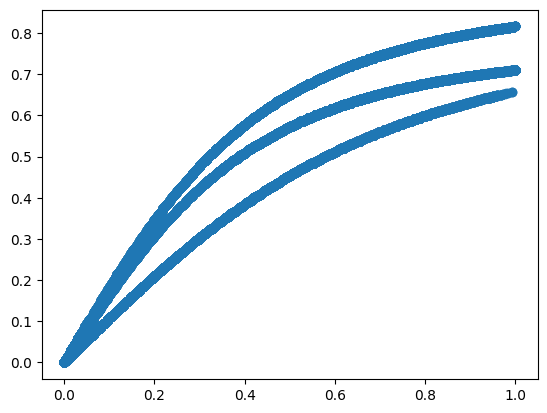

In [58]:
plt.scatter(kk.ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

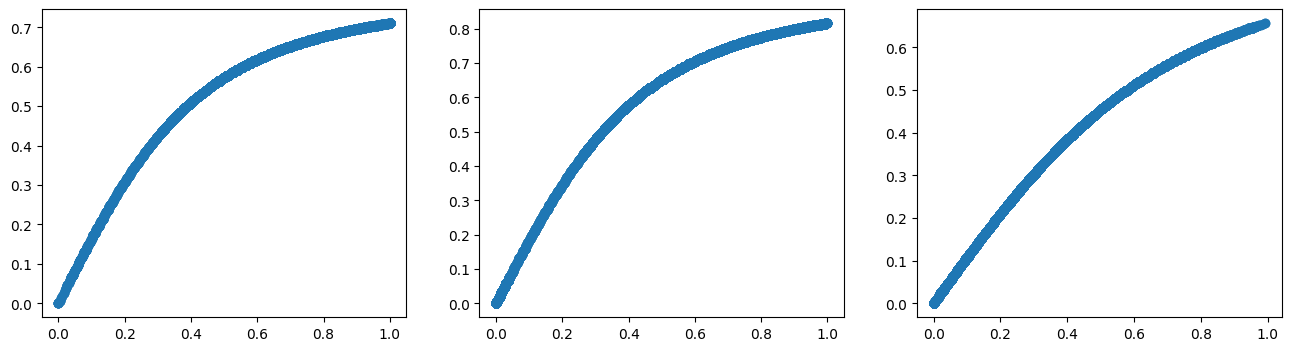

In [59]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
for i, ax in enumerate(axes.ravel()):
    ax.scatter(kk[...,i].ravel(),
            extras["intermediates"][layer_name]["__call__"][0][...,i].ravel())
plt.show()

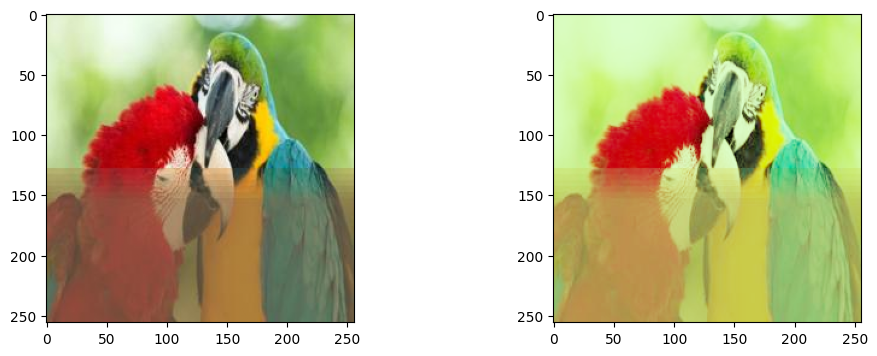

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].imshow(kk[0])
axes[1].imshow(extras["intermediates"][layer_name]["__call__"][0][0]/extras["intermediates"][layer_name]["__call__"][0][0].max())
plt.show()

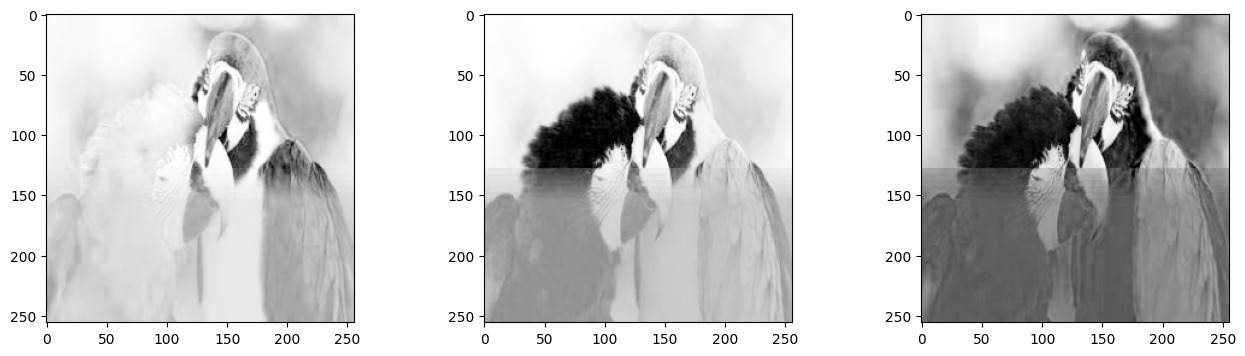

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### J & H

In [68]:
prev_layer = "GDN_0"
layer_name = "Conv_0"

In [69]:
state.params["Conv_0"]

{'bias': array([-0.46039224,  0.24264725,  0.25439617], dtype=float32),
 'kernel': array([[[[ 0.19776805,  0.26147854,  0.58382523],
          [ 0.47422048,  0.73200357, -0.0278701 ],
          [ 0.07504201,  0.22712806, -1.415839  ]]]], dtype=float32)}

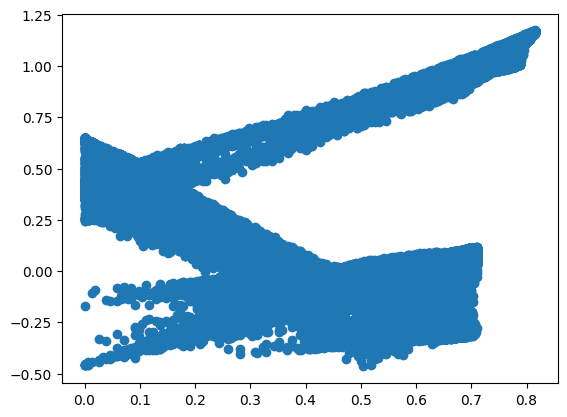

In [70]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

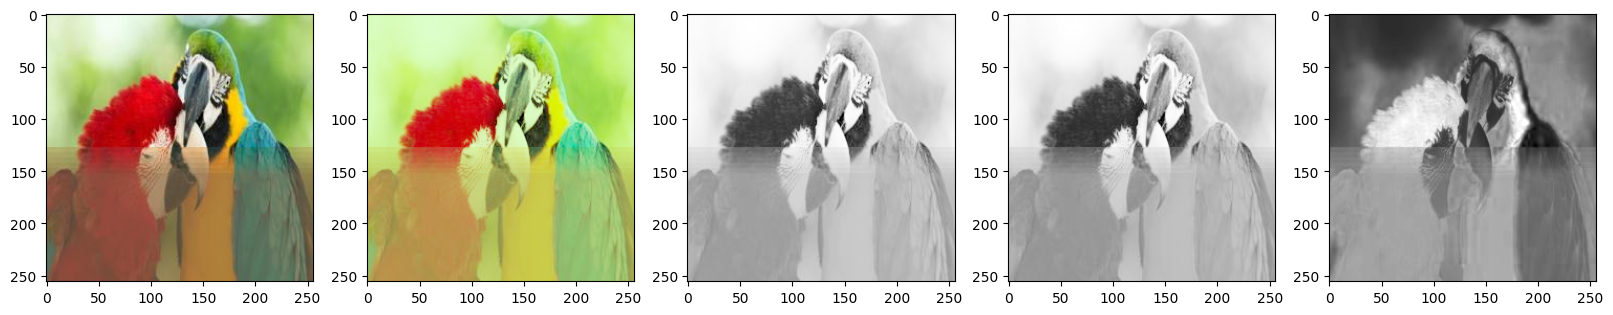

In [71]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
axes[0].imshow(kk[0])
axes[1].imshow(extras["intermediates"][prev_layer]["__call__"][0][0]/extras["intermediates"][prev_layer]["__call__"][0][0].max())
for i, ax in enumerate(axes[2:]):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### DN 1

In [72]:
prev_layer = "Conv_0"
layer_name = "GDN_1"
state.params[layer_name]

{'Conv_0': {'bias': array([0.14258687, 0.5612268 , 1.1748836 ], dtype=float32),
  'kernel': array([[[[0.        , 0.        , 0.        ],
           [0.2018936 , 0.26771787, 0.48700878],
           [0.        , 0.09399772, 1.5108938 ]]]], dtype=float32)}}

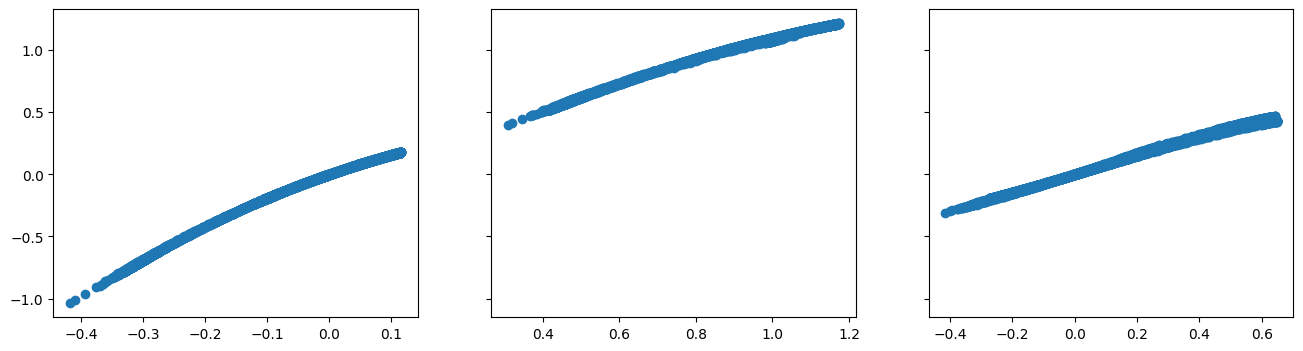

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(16,4), sharey=True)
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()

### CSF (DoG)

In [99]:
prev_layer = "GDN_1"
layer_name = "Conv_1"
state.params[layer_name]["kernel"]

array([[[[ 8.65098685e-02,  1.73420981e-02, -1.07282586e-01,
          -1.73054397e-01,  4.07109782e-02, -7.06328377e-02],
         [ 1.73269995e-02,  2.30659544e-02,  1.89030804e-02,
          -5.47431000e-02, -1.07060280e-02, -2.24005468e-02],
         [-6.16540462e-02, -5.60060702e-02, -2.22640019e-02,
          -4.89208624e-02,  1.85664382e-03, -4.22455184e-03]],

        [[ 2.64793125e-05, -7.90088437e-03, -1.16682775e-01,
          -1.03780746e-01, -1.63277537e-02,  2.12078821e-02],
         [ 2.01871917e-02,  3.95497121e-02,  2.49087140e-02,
          -4.40294482e-02, -1.94920786e-02, -1.06527293e-02],
         [ 3.27584939e-03,  5.68134384e-03, -2.61673983e-02,
          -5.35645261e-02, -1.88742671e-02, -1.35715054e-02]],

        [[-7.02804700e-02, -8.95965192e-03, -3.37312855e-02,
          -1.34435743e-01,  6.08491246e-03, -4.80057448e-02],
         [ 8.58422893e-04, -8.89407750e-03, -4.45048735e-02,
          -2.97354050e-02, -2.64681615e-02,  1.28350370e-02],
         [ 9

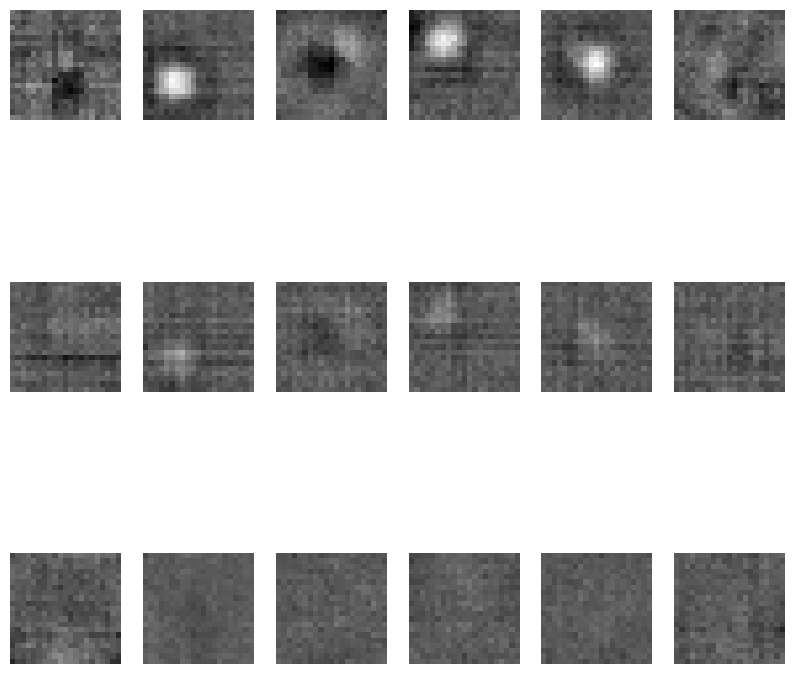

In [101]:
fig, axes = plt.subplots(3, 6, figsize=(10,10))
m, M = state.params[layer_name]["kernel"].min(), state.params[layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.params[layer_name]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        ax.axis("off")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

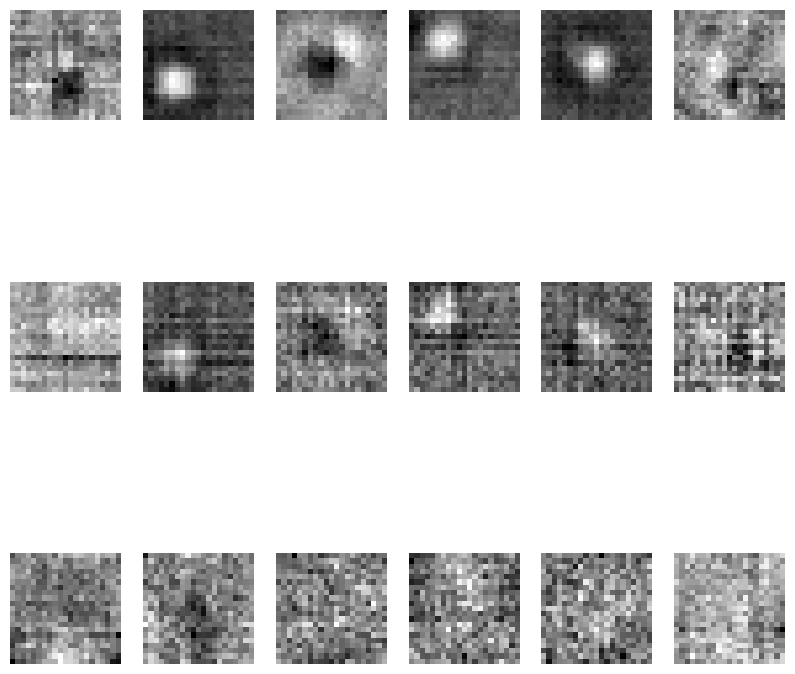

In [102]:
fig, axes = plt.subplots(3, 6, figsize=(10,10))
m, M = state.params[layer_name]["kernel"].min(), state.params[layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.params[layer_name]["kernel"][:,:,i,j], cmap="gray")
        ax.axis("off")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### DN (2)

In [103]:
prev_layer = "Conv_1"
layer_name = "GDN_2"
# state.params[layer_name]

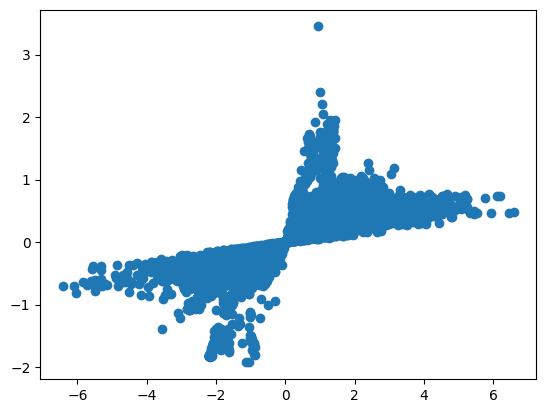

In [82]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2)).ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

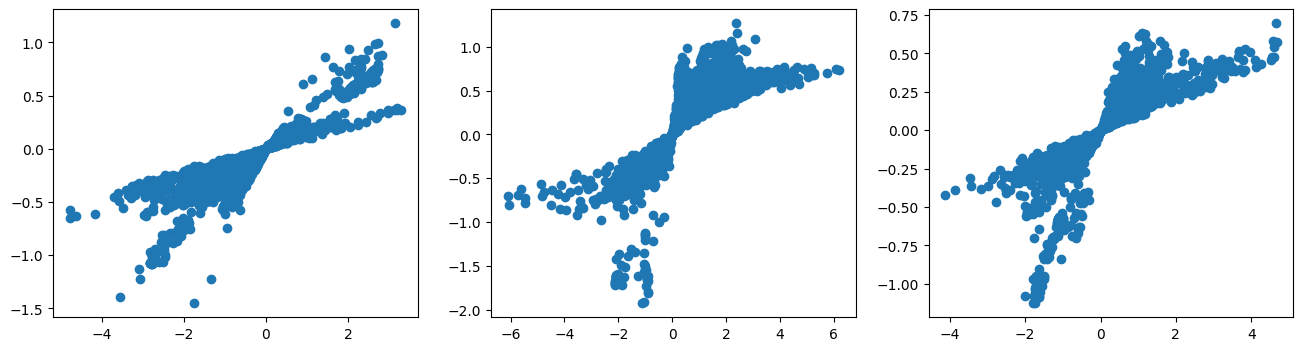

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()

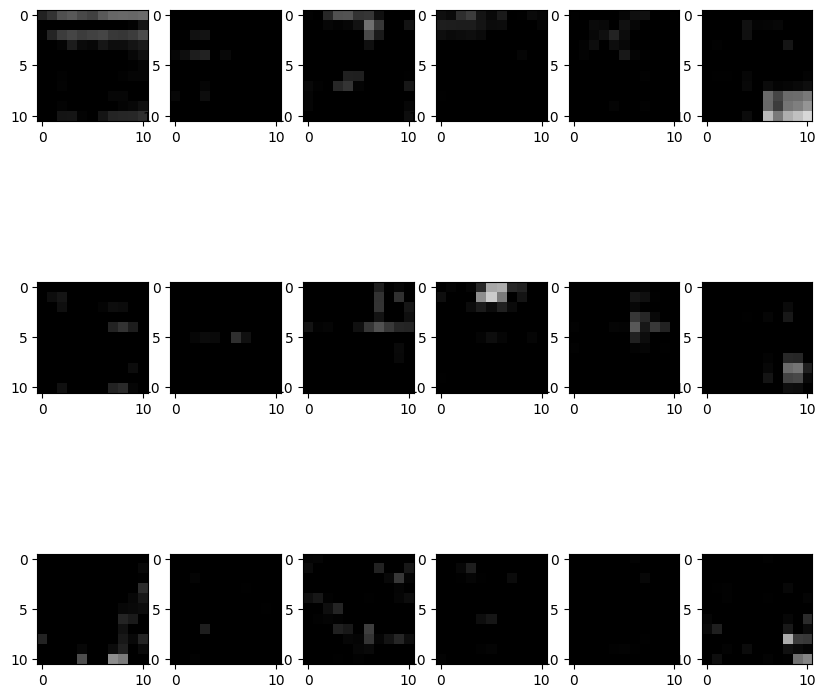

In [104]:
fig, axes = plt.subplots(3, 6, figsize=(10,10))
m, M = state.params[layer_name]["Conv_0"]["kernel"].min(), state.params[layer_name]["Conv_0"]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.params[layer_name]["Conv_0"]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

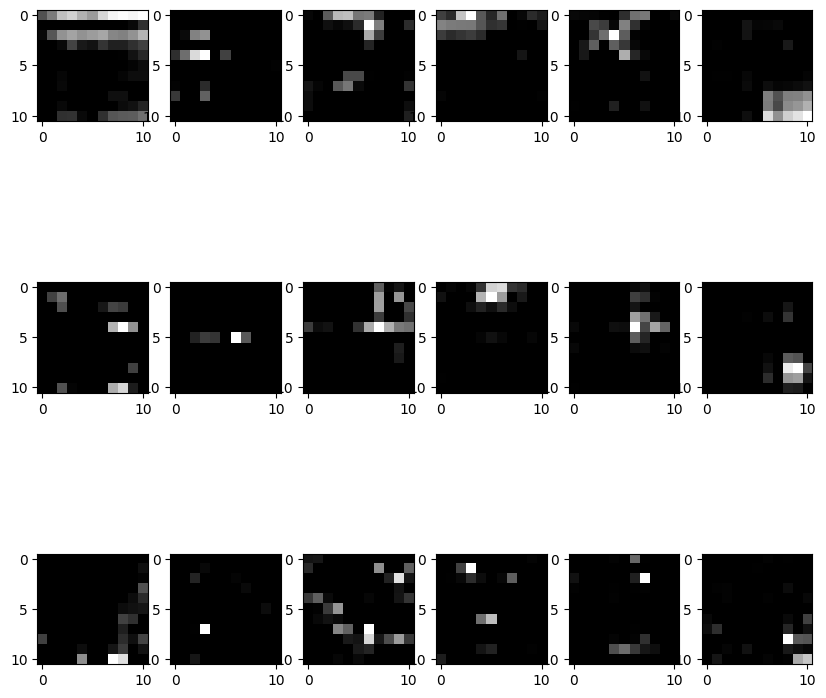

In [105]:
fig, axes = plt.subplots(3, 6, figsize=(10,10))
m, M = state.params[layer_name]["Conv_0"]["kernel"].min(), state.params[layer_name]["Conv_0"]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.params[layer_name]["Conv_0"]["kernel"][:,:,i,j], cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### Gabor

In [107]:
prev_layer = "GDN_2"
layer_name = "Conv_2"
# state.params[layer_name]

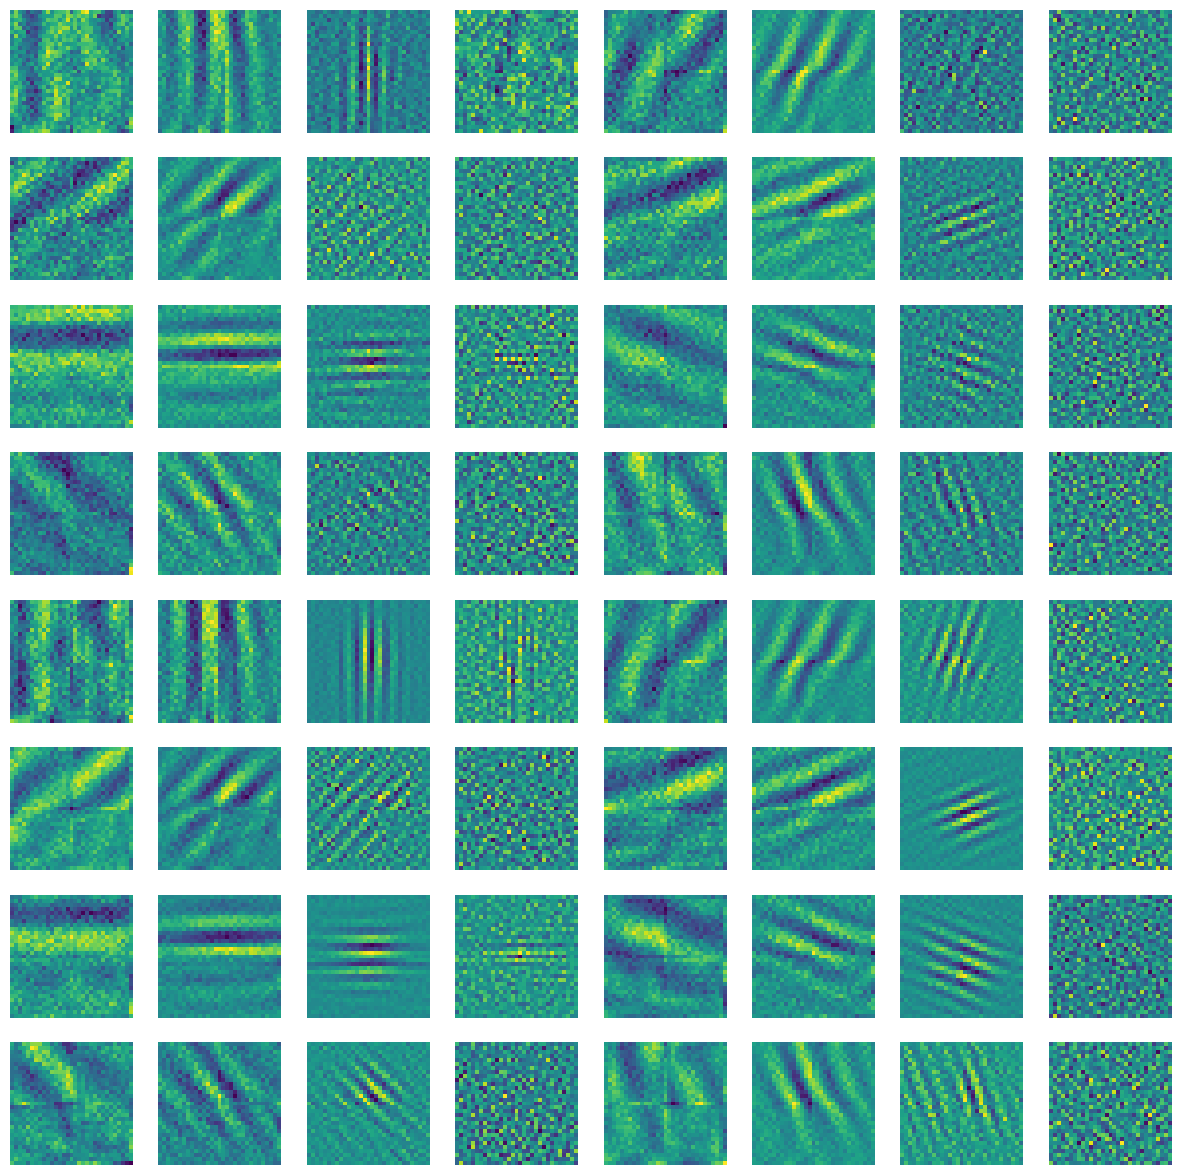

In [111]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.params[layer_name]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [92]:
kernel = state.params[layer_name]["kernel"]
kernel.shape

(31, 31, 6, 128)

In [93]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft, axes=(0,1))
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((31, 31, 128), (31, 31))

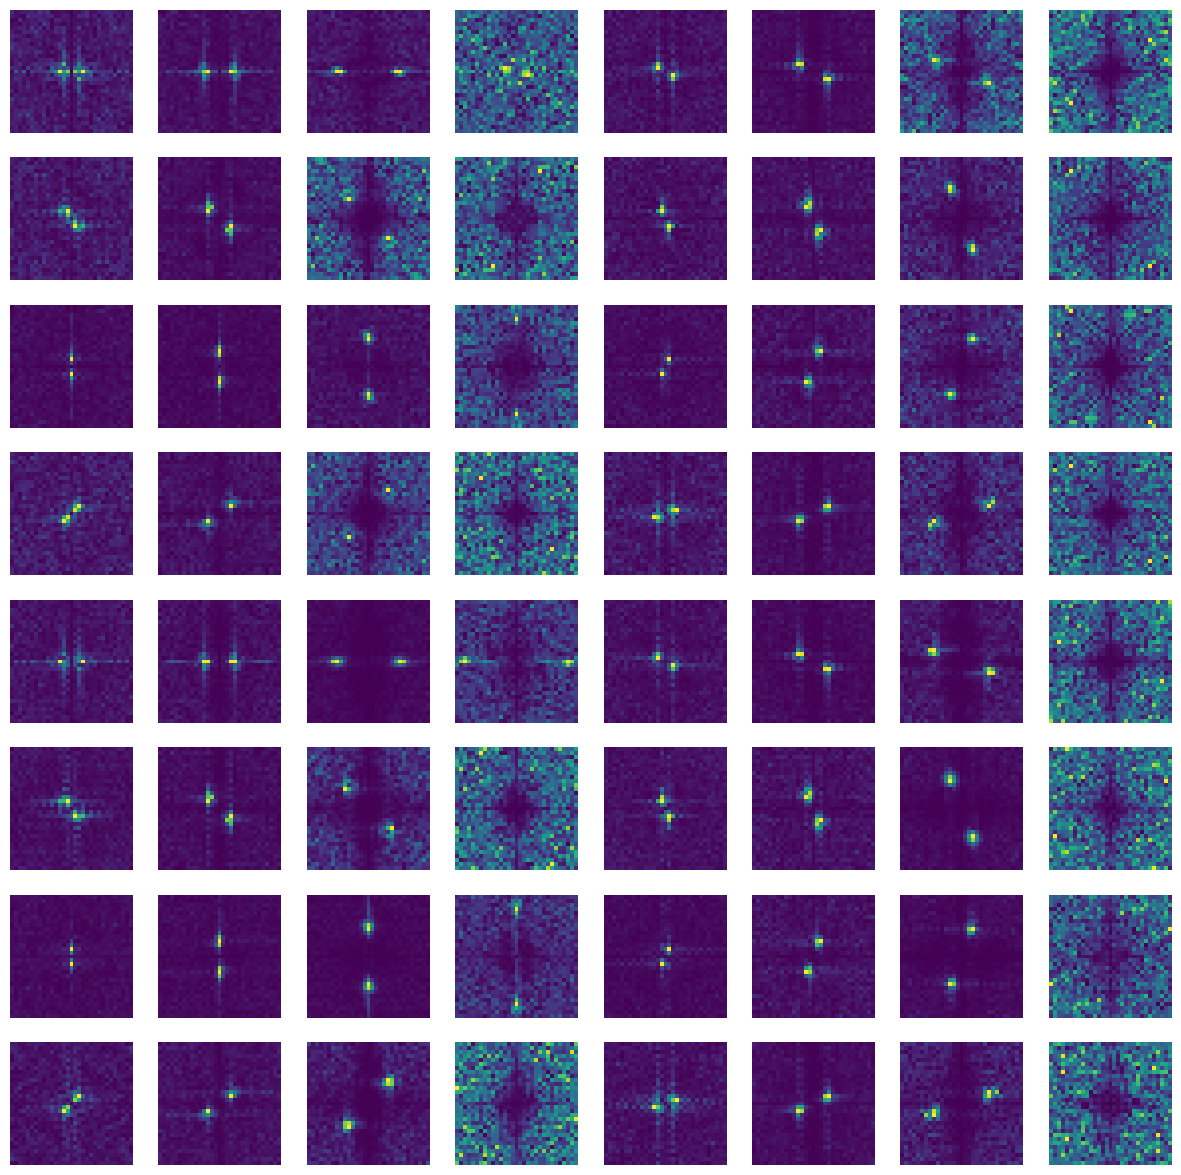

In [94]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

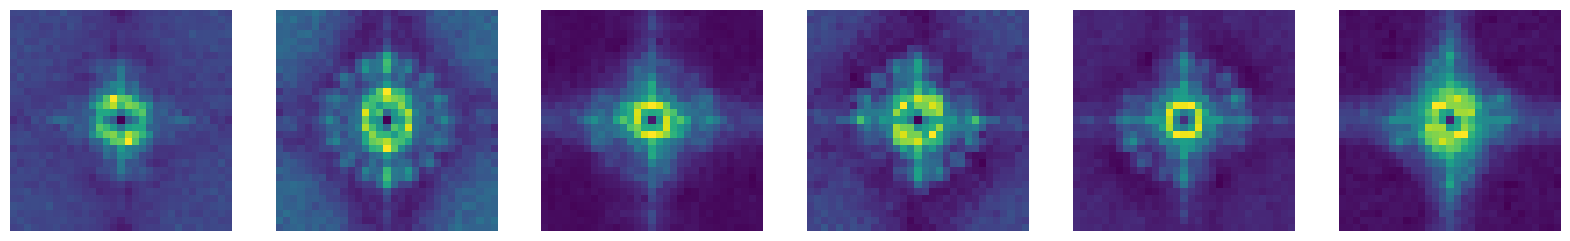

In [98]:
fig, axes = plt.subplots(1,6, figsize=(20,4))
for i, ax in enumerate(axes.ravel()):
    kernel_f_fft = jnp.fft.fftn(kernel[:,:,i,:], axes=(0,1))
    kernel_f_fft = jnp.fft.fftshift(kernel_f_fft, axes=(0,1))
    kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
    ax.imshow(kernel_f_fft_abs_sum)
    ax.axis("off")
plt.show()

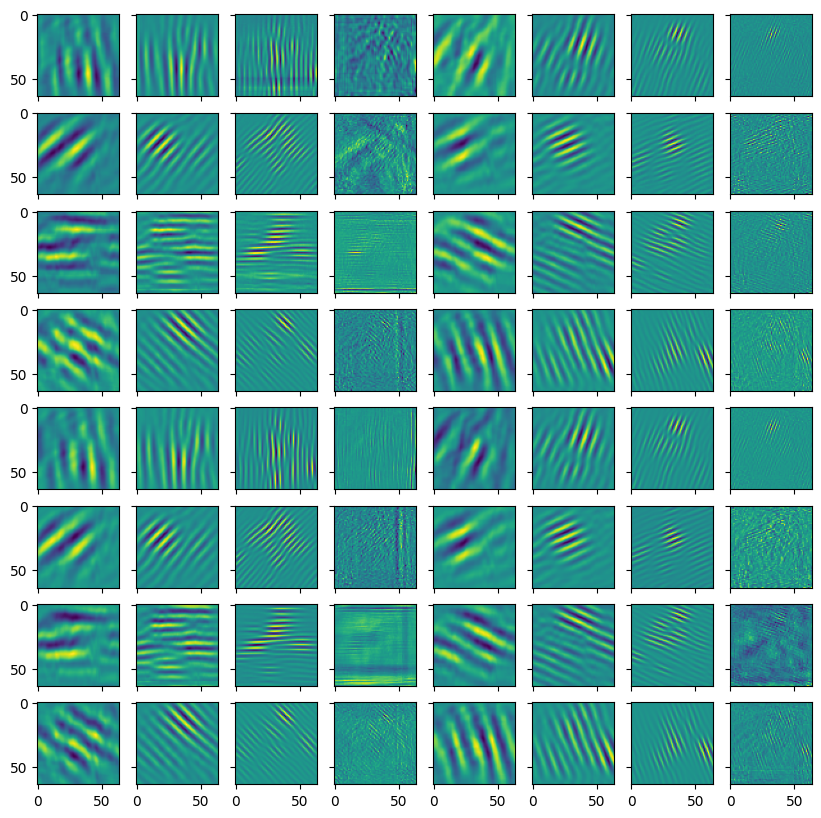

In [113]:
fig, axes = plt.subplots(8, 8, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i])
plt.show()
plt.show()

### DN (3)

In [114]:
prev_layer = "Conv_2"
layer_name = "GDN_3"
# state.params[layer_name]

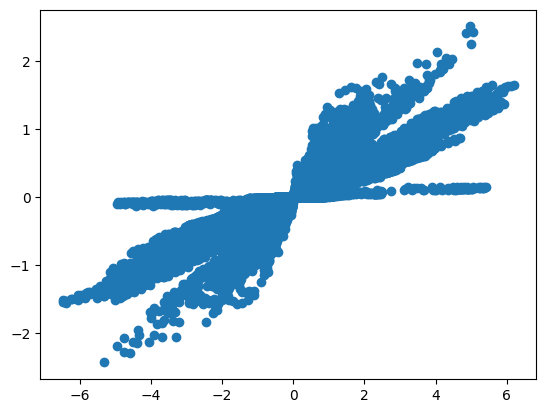

In [115]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

In [117]:
extras["intermediates"][prev_layer]["__call__"][0].shape

(1, 64, 64, 128)

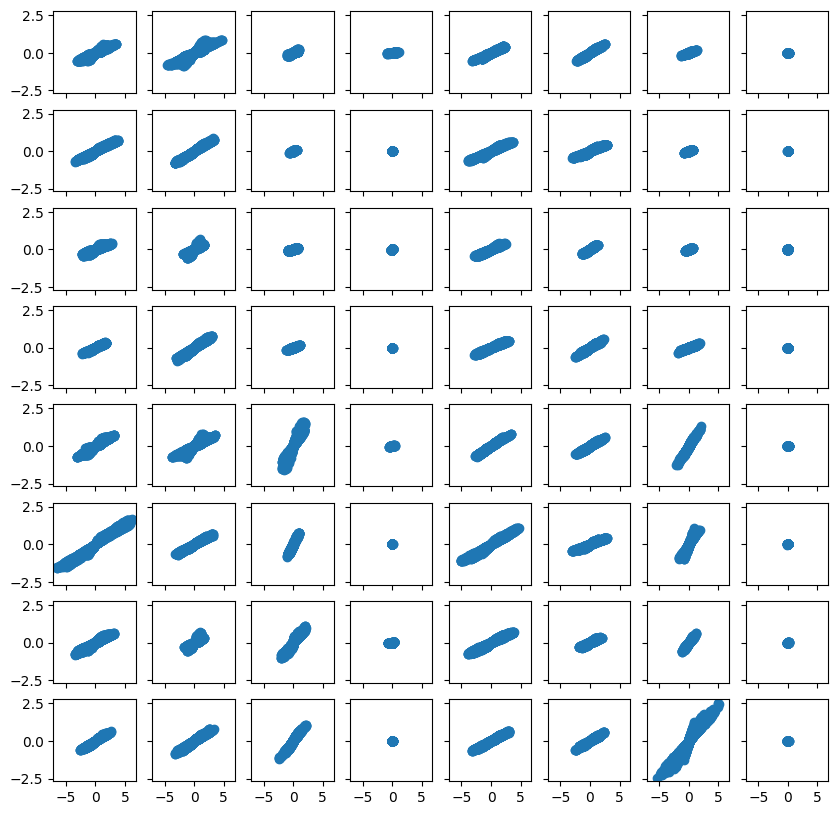

In [119]:
fig, axes = plt.subplots(8, 8, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.scatter(extras["intermediates"][prev_layer]["__call__"][0][0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()
plt.show()

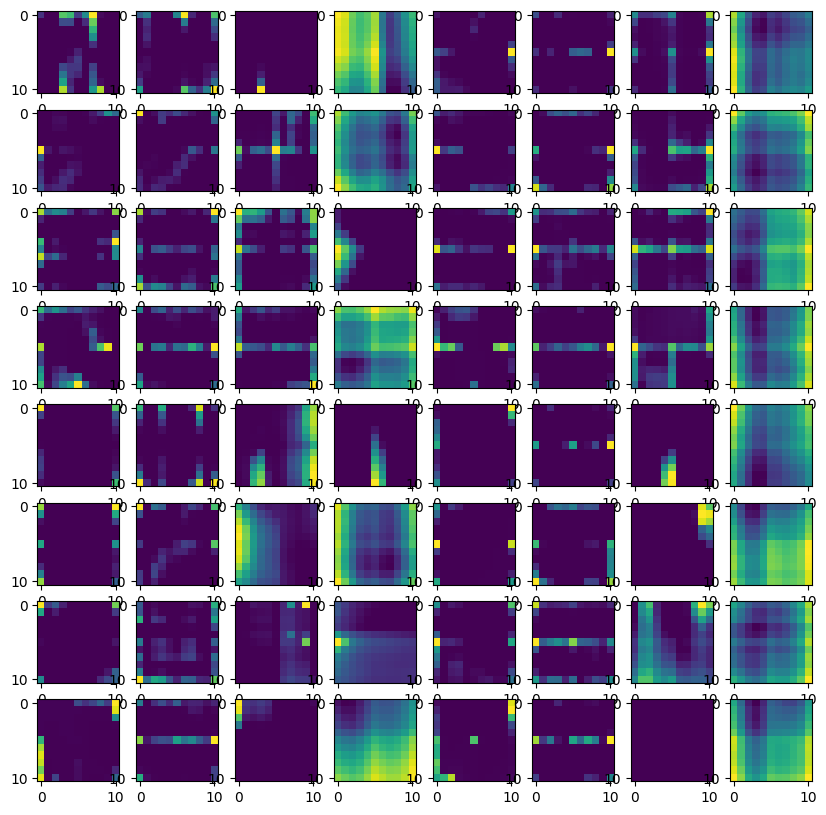

In [121]:
fig, axes = plt.subplots(8, 8, figsize=(10,10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.params[layer_name]["Conv_0"]["kernel"][:,:,0,i])
plt.show()

### Final output

(8, 16)


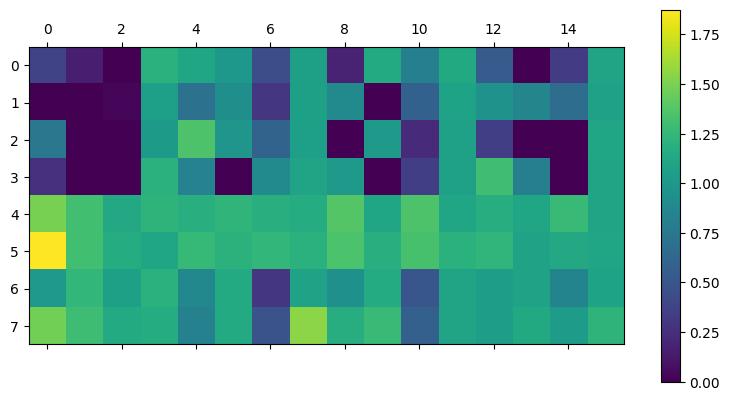

In [123]:
bias_m = rearrange(state.params[layer_name]["Conv_0"]["bias"], "(h w) -> h w", h=8, w=16)
print(bias_m.shape)
plt.matshow(bias_m)
plt.colorbar()
plt.show()

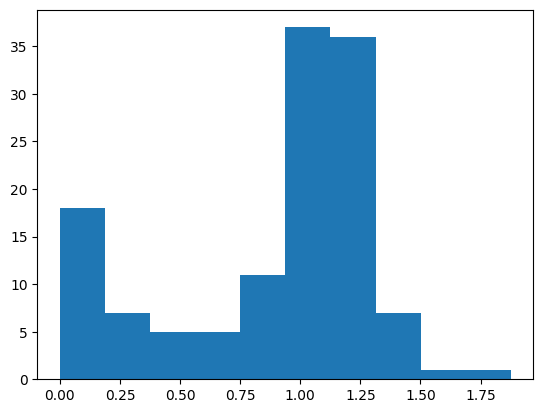

In [124]:
plt.hist(state.params[layer_name]["Conv_0"]["bias"])
plt.show()

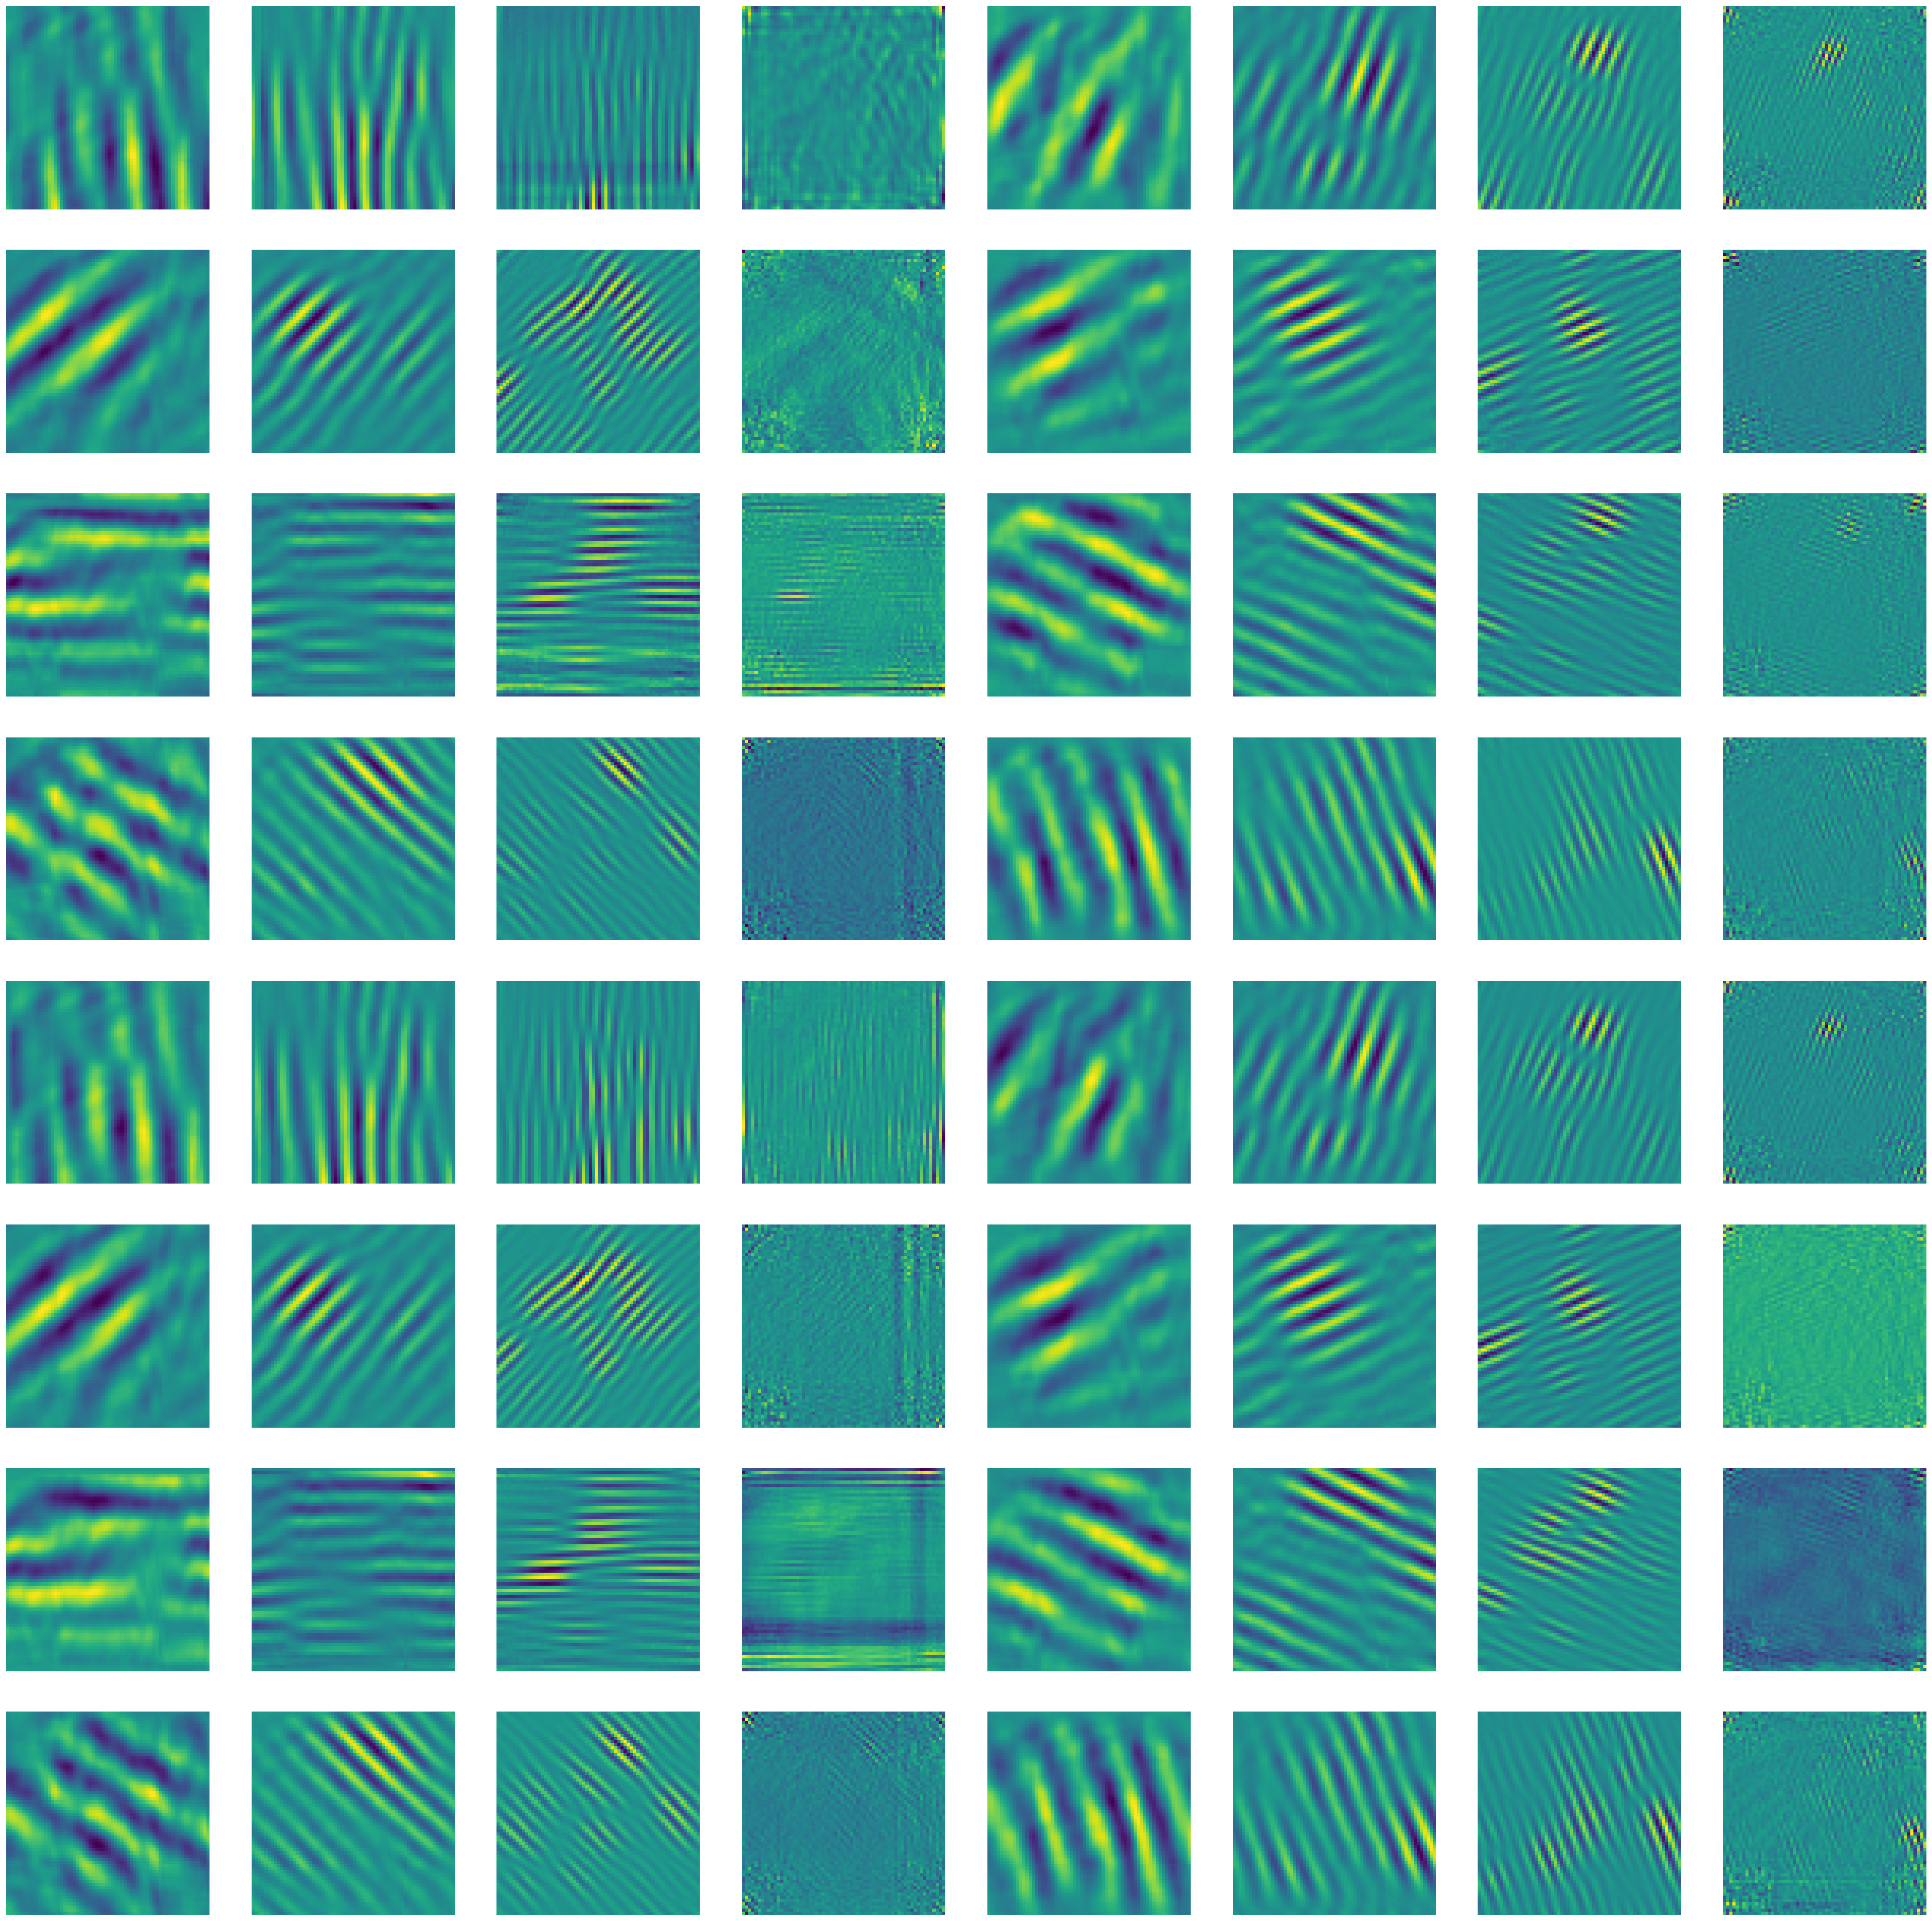

In [125]:
fig, axes = plt.subplots(8,8, figsize=(40,40))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(outputs[0,:,:,i])
    ax.axis("off")
plt.show()